In [80]:
import nilearn
from nilearn import plotting
from nilearn import datasets
from nilearn.image import mean_img
from nilearn import image
import numpy as np
import pandas as pd
import os
from nilearn.datasets import MNI152_FILE_PATH
from nilearn.image import math_img


Imagem Estrutural deste participante

In [81]:
#As primeiras 3 imagens são a imagem original 

/Users/ananogueira/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


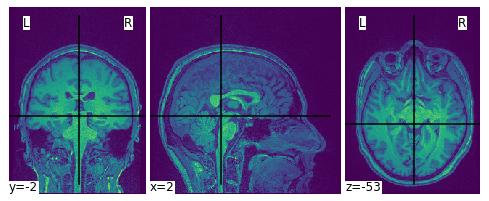

In [82]:
t1w_file_path='/Users/ananogueira/Desktop/Documents/BIDS/sub-0001/ses-001/anat/sub-0001_ses-001_run-01_T1w.nii.gz'
plotting.plot_img(t1w_file_path)

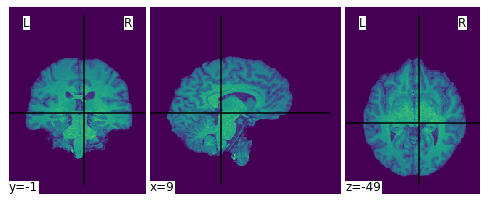

In [83]:
t1w_brain_file_path='/Users/ananogueira/Desktop/Documents/BIDS/sub-0001/ses-001/anat/sub-0001_ses-001_run-01_T1w_brain.nii.gz'

plotting.plot_img(t1w_brain_file_path)

Brain extraction

In [84]:
#Retirou-se o cranio através de um algoritmo que está no FSL chamado BET

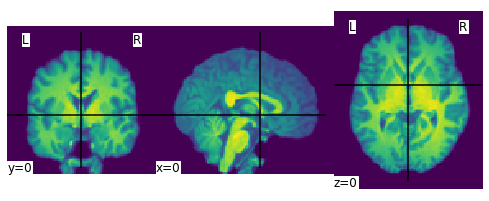

In [85]:
t1w_prepro_file_path='/Users/ananogueira/Desktop/Documents/BIDS/sub-0001/ses-001/run-1.feat/reg/highres2standard.nii.gz'

cut_coords=(0, 0, 0)
plotting.plot_img(t1w_prepro_file_path, cut_coords)

In [86]:
#Imagem passada para standard 

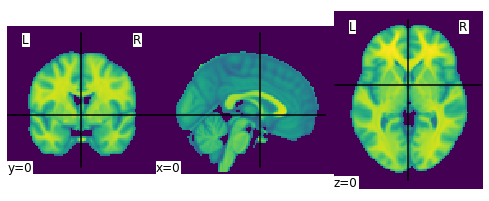

In [87]:
plotting.plot_img(datasets.MNI152_FILE_PATH, cut_coords)

In [88]:
# (0,0,0) no standard MNI (mas tb em Talairach) aponta sempre para uma estrutura anatómica chamada de comissura anterior

In [89]:
#Conclusão final: Retirou-se o cranio e alinhou-se todas as posições num standart

DADOS FUNCIONAIS 

In [90]:
#Ver o pré-processamento do FSL

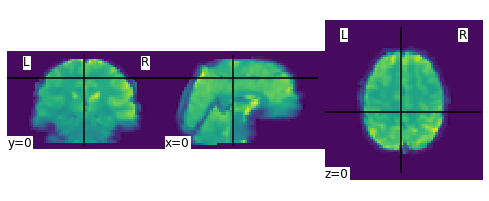

In [91]:
func_data_preproc='/Users/ananogueira/Desktop/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data.nii.gz'

mean_fmri_img=mean_img(func_data_preproc)
plotting.plot_img(mean_fmri_img, cut_coords)

In [92]:
#Como não está alinhado queremos alinhar também para um standart

(91, 109, 91)


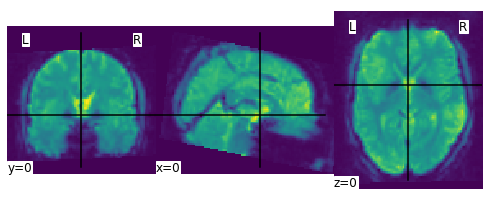

In [93]:
func_data_preproc_2high='/Users/ananogueira/Desktop/Documents/BIDS/sub-0001/ses-001/run-1.feat/reg/example_func2standard.nii.gz'

mean_fmri_img_2high=mean_img(func_data_preproc_2high)

print(image.load_img(func_data_preproc_2high).shape)

plotting.plot_img(mean_fmri_img_2high, cut_coords)

In [94]:
#Dados alinhados
#Também representa a média de todos os volumes funcionais 

(91, 109, 91, 222)


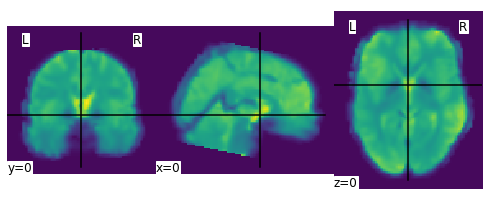

In [95]:
func_data_preproc2standard='/Users/ananogueira/Desktop/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data2standard.nii.gz'
print(image.load_img(func_data_preproc2standard).shape)

mean_fmri_img_2standard=mean_img(func_data_preproc2standard)
plotting.plot_img(mean_fmri_img_2standard, cut_coords)

In [96]:
#Smooth
#Temos 222 volumes 

In [97]:
#Já temos os dados prontos para fazer operações 

In [98]:
#Acabou o pré-processamento de dados 

Definir os momentos em que a pessoa estava a fazer alguma coisa e os momentos em que a pessoa estava a descansar

Design Matrix

In [99]:
# Set variables
root_data='/Users/ananogueira/Desktop/Documents/BIDS/'
sub='sub-0001'
ses='ses-001'
file_sep="/"

# data folder
data_path=root_data+file_sep+sub+file_sep+ses
print('The data is in this folder - '+data_path)

# project folder
root_project="/Users/ananogueira/Desktop/Documents/MVPA-speech_project"



The data is in this folder - /Users/ananogueira/Desktop/Documents/BIDS//sub-0001/ses-001


In [100]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 2.5  # tempo de repetição
n_scans = 222  #numero de volumes 
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# load events.tsv
events_PATH='/Users/ananogueira/Desktop/Documents/MVPA-speech_project/convert-bids-admin/DOCKER/events.tsv'
events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")
print(events_df.head())

  trial_type  onset  duration
0  Baseline     0.0      12.5
1      Task    15.0      27.5
2  Baseline    45.0      12.5
3      Task    60.0      27.5
4  Baseline    90.0      12.5


In [101]:
#Informação sobre o que a pessoa estava a fazer em determinado tempo


<AxesSubplot:label='conditions', ylabel='scan number'>

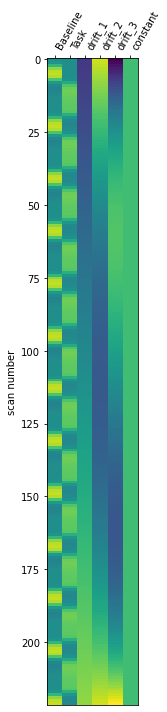

In [102]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

plot_design_matrix(design_matrix)

In [103]:
#Ver se a pessoa estava a descansar (baseline) ou a fazer a tarefa (Task) (Preditores de interesse)

Estatistica de primeira ordem 

In [104]:
#Comportamento do voxel ao longo do tempo 

In [105]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
basic_contrasts['+Task-Baseline'] = (
    basic_contrasts['Task ']
    - basic_contrasts['Baseline '])

In [106]:
from nilearn.glm.first_level import FirstLevelModel

fmri_img='/Users/ananogueira/Desktop/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data2standard.nii.gz'


print('Fitting a GLM')
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix)

Fitting a GLM


In [107]:
mean_image = mean_img(fmri_img)
z_map = fmri_glm.compute_contrast(basic_contrasts['+Task-Baseline'], output_type='z_score')

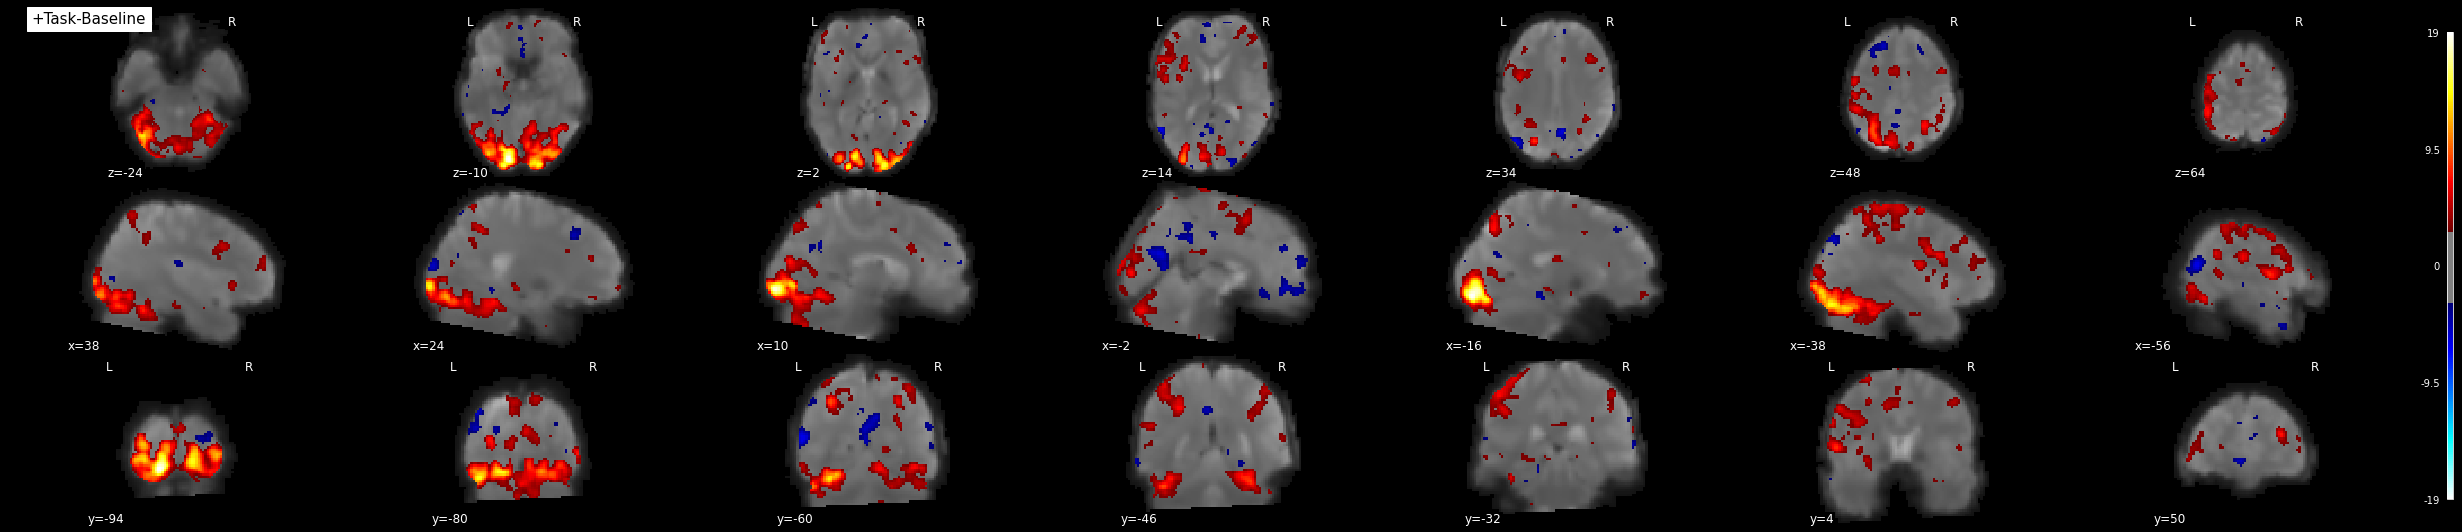

In [108]:
# plot the contrasts 
# the display is overlayed on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
plotting.plot_stat_map(
    z_map, bg_img=mean_image, threshold=3, display_mode='mosaic', black_bg=True, title='+Task-Baseline')
plotting.show()


In [109]:

#Estatistica Univariada em Ressonacia Funcional

Decoding


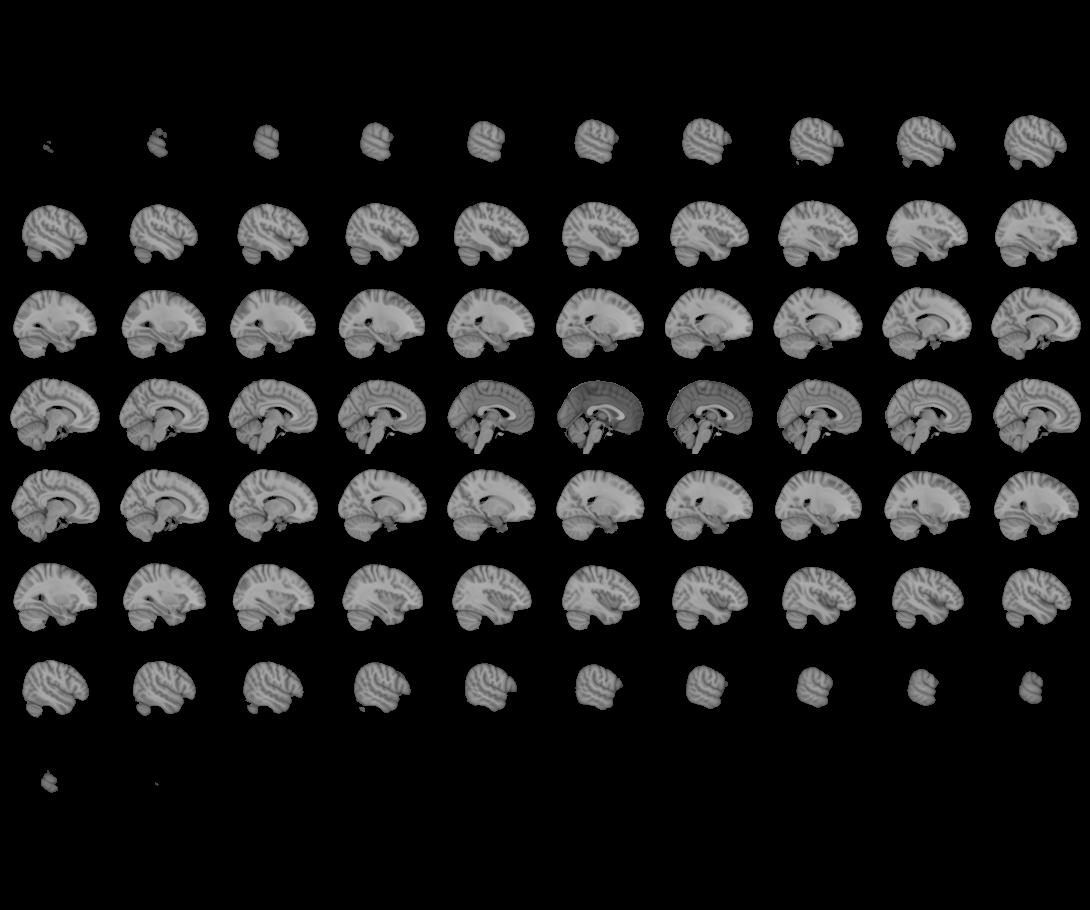
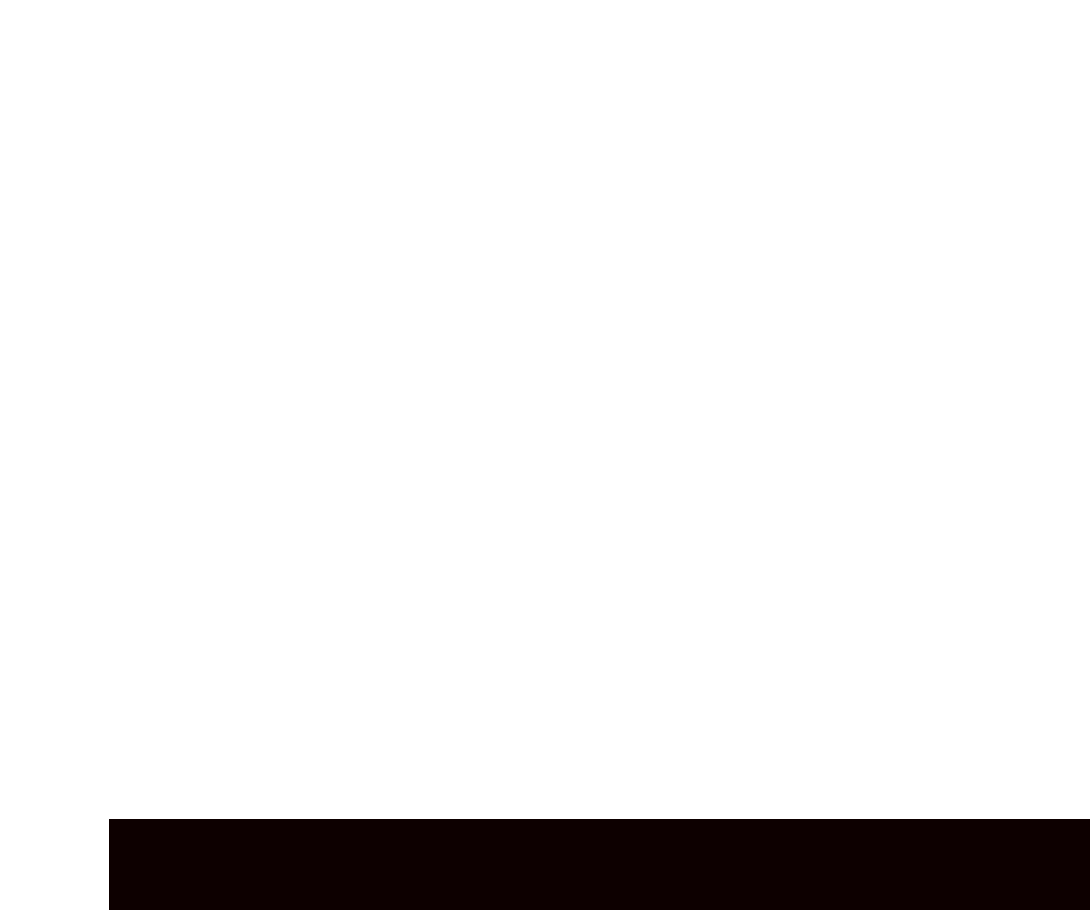

In [110]:
from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 
atlas_filename = dataset.maps


brain_mask = mean_img([math_img('img == %d'  %i, img=atlas_filename) for i in [48, 49]])
plotting.view_img(brain_mask)

In [111]:
from nilearn.decoding import Decoder 

decoder = Decoder(estimator='svc', mask=brain_mask) 

/Users/ananogueira/.local/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:140: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  warnings.warn(
/Users/ananogueira/.local/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/ananogueira/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


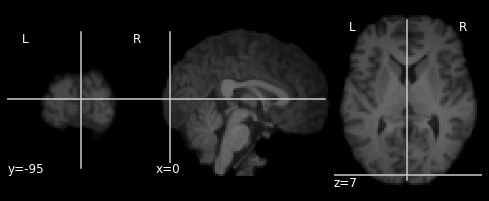

In [112]:
plotting.plot_roi(brain_mask, bg_img=t1w_prepro_file_path,
                  cmap='Paired')

In [113]:
fmri_niiimgs=image.load_img('/Users/ananogueira/Desktop/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data2standard.nii.gz'
)
fmri_niiimgs.shape

(91, 109, 91, 222)

In [114]:
decoder.fit(trainset, conditions[:-50]) 

TREINO

In [115]:
print(events_df)

   trial_type  onset  duration
0   Baseline     0.0      12.5
1       Task    15.0      27.5
2   Baseline    45.0      12.5
3       Task    60.0      27.5
4   Baseline    90.0      12.5
5       Task   105.0      27.5
6   Baseline   135.0      12.5
7       Task   150.0      27.5
8   Baseline   180.0      12.5
9       Task   195.0      27.5
10  Baseline   225.0      12.5
11      Task   240.0      27.5
12  Baseline   270.0      12.5
13      Task   285.0      27.5
14  Baseline   315.0      12.5
15      Task   330.0      27.5
16  Baseline   360.0      12.5
17      Task   375.0      27.5
18  Baseline   405.0      12.5
19      Task   420.0      27.5
20  Baseline   450.0      12.5
21      Task   465.0      27.5
22  Baseline   495.0      12.5
23      Task   510.0      27.5
24  Baseline   540.0      12.5


In [116]:
idxs=events_df['onset']/tr
conditions = []

for i in range(len(events_df)):
    idx_2=((events_df['duration'][i]/tr))+1
    for j in range(int(idx_2)):
        conditions.append(events_df['trial_type'][i])

In [117]:
print(conditions)

['Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Task ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Baseline ', 'Bas

In [118]:
from nilearn.image import index_img
trainset = index_img(fmri_niiimgs, slice(0, -50))
trainset.shape

(91, 109, 91, 172)

TESTE

In [119]:
testset = index_img(fmri_niiimgs, slice(-50,None))
testset.shape

(91, 109, 91, 50)

In [120]:
prediction=decoder.predict(testset)

In [121]:
print((prediction == conditions[-50:]).sum() / float(len(conditions[-50:])))

0.76



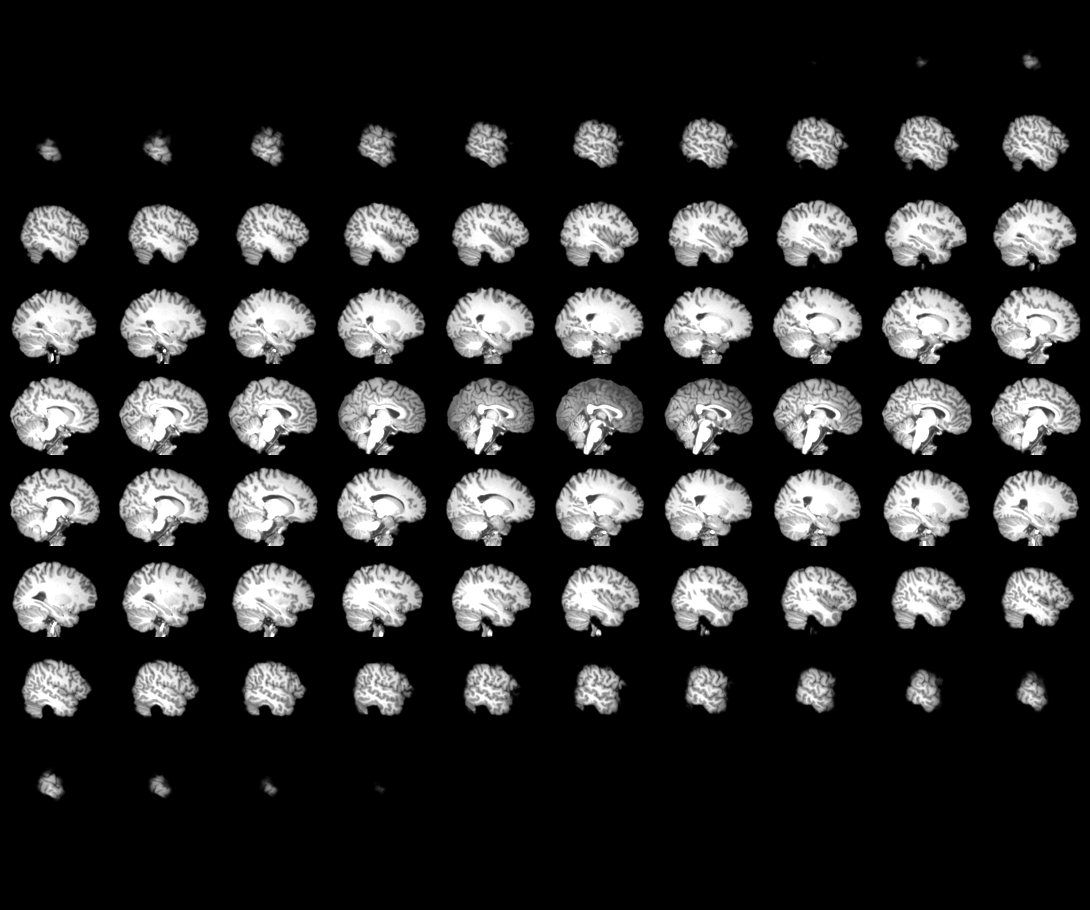
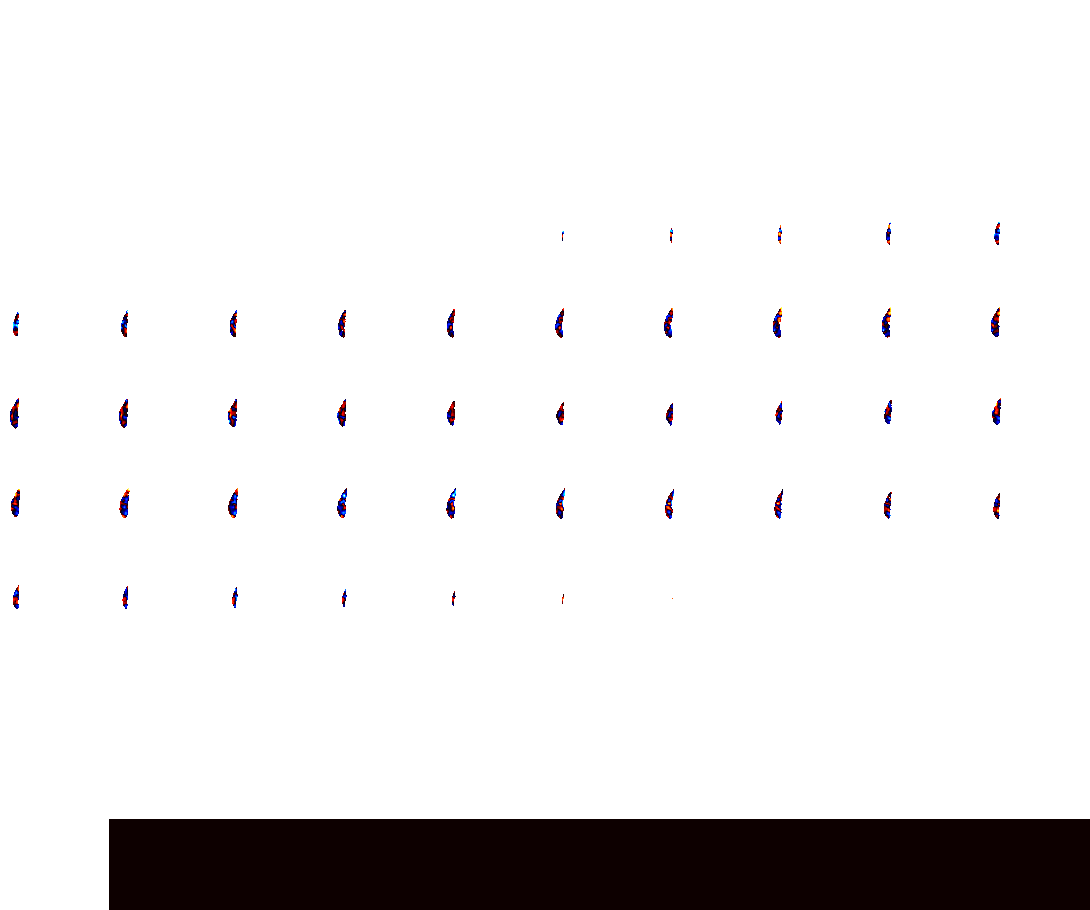

In [122]:
plotting.view_img(
    decoder.coef_img_['Task '], bg_img=t1w_prepro_file_path,
    title="SVM weights", dim=-1
)